In [1]:
# !pip install Orange3
from utils.base_helpers import download_artifact
import pandas as pd
import wandb
import plotly.express as px

wandb.init(project="keras")

wandb: Currently logged in as: merts (use `wandb login --relogin` to force relogin)
2022-06-03 14:30:46.159269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 14:30:46.159286: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Scale Back

In [2]:
from utils.base_helpers import DataReader

ratios = [0.56095, 0.082, 0.082, 0.08288, 0.0838, 0.0838]
train_ratio_, valid_ratio_, test_ratio_ = ratios[:3]
print("Starting")
data = DataReader(number_of_plants=90)
data.process(train_ratio=train_ratio_, valid_ratio=valid_ratio_, test_ratio=test_ratio_, scaler=None, expand=False)

Starting
Train start and end dates:	 2019-01-26 03:00:00 	 2020-10-02 22:00:00
Validation start and end dates:	 2020-10-02 23:00:00 	 2020-12-31 23:00:00
Test start and end dates:	 2021-01-01 00:00:00 	 2021-03-31 23:00:00


In [3]:
scalers = {}
from sklearn.preprocessing import MinMaxScaler as scaler_

for plant_id in data.train_df.rt_plant_id.unique():
    scalers[plant_id] = scaler_()
    scalers[plant_id] = scalers[plant_id].fit(data.train_df.loc[data.train_df["rt_plant_id"] == plant_id][["production"]])

In [62]:
import numpy as np

class Metrics:
    def __init__(self, df):
        df_ = df.copy()
        self.df = self.inverse_transform(df_)
        self.wmape_func = lambda x: self.calculate_wmape(x["predictions"], x["actuals"])
        self.bias_func = lambda x: self.calculate_bias(x["predictions"], x["actuals"])
    
    @staticmethod
    def inverse_transform(predictions):
        for plant_id in data.plants:
            predictions.loc[predictions["rt_plant_id"] == plant_id, ["actuals", "predictions"]] = scalers[plant_id].inverse_transform(predictions.loc[predictions["rt_plant_id"] == plant_id, ["actuals", "predictions"]])
        predictions[["actuals", "predictions"]] = predictions[["actuals", "predictions"]].round(2)
        return predictions
        
    def calculate(self):
        self.df["hour"] = self.df["forecast_dt"].dt.hour
        self.df["date"] = self.df["forecast_dt"].dt.date
        self.df["week"] = self.df["forecast_dt"].dt.isocalendar().week
        self.df["month"] = self.df["forecast_dt"].dt.month
        
        self.wmape = self.wmape_func(self.df)
        self.bias = self.bias_func(self.df)
        
        self.dwmape = self.df.groupby("date").apply(self.wmape_func)
        self.dbias = self.df.groupby("date").apply(self.bias_func)
        self.dwmape_median, self.dwmape_std = self.dwmape.median(), self.dwmape.std()
        self.dbias_median, self.dbias_std = self.dbias.median(), self.dbias.std()

        self.wwmape = self.df.groupby("week").apply(self.wmape_func)
        self.wbias = self.df.groupby("week").apply(self.bias_func)
        self.wwmape_median, self.wwmape_std = self.wwmape.median(), self.wwmape.std()
        self.wbias_median, self.wbias_std = self.wbias.median(), self.wbias.std()

        self.pwmape = self.df.groupby("rt_plant_id").apply(self.wmape_func)
        self.pbias = self.df.groupby("rt_plant_id").apply(self.bias_func)
        self.pwmape_median, self.pwmape_std = self.pwmape.median(), self.pwmape.std()
        self.pbias_median, self.pbias_std = self.pbias.median(), self.pbias.std()

        self.hwmape = self.df.groupby("hour").apply(self.wmape_func)
        self.hbias = self.df.groupby("hour").apply(self.bias_func)
        self.hwmape_median, self.hwmape_std = self.hwmape.median(), self.hwmape.std()
        self.hbias_median, self.hbias_std = self.hbias.median(), self.hbias.std()

    def to_df(self, model, how="overall"):
        assert how in ["overall", "date", "week", "rt_plant_id", "hour"]
        cols = ["wmape_median", "wmape_std", "bias_median", "bias_std"]
        map_dict = {
            "overall": ["wmape", "bias"],
            "date": ["d"+col for col in cols],
            "week": ["w"+col for col in cols],
            "rt_plant_id": ["p"+col for col in cols],
            "hour": ["h"+col for col in cols],
        }
        out_df = pd.DataFrame({k:[v] for k,v in self.__dict__.items() if k in map_dict[how]})
        out_df["model"] = model
        return out_df
            
    @staticmethod
    def calculate_wmape(preds, actuals):
        return np.sum(np.abs(preds-actuals)) / np.sum(np.abs(actuals))

    @staticmethod
    def calculate_bias(preds, actuals):
        return np.sum(preds-actuals) / np.sum(actuals)
    

class Mert:
    def __init__(self, ids):
        self.ids = ids
        self.data = []
        
    def read(self):
        for wandb_id in self.ids:
            self.data.append(self.artifacts(wandb_id))
        self.data = pd.concat([i["predictions"] for i in self.data])
        
    def generate(self, name):
        self.read()
        self.metrics = Metrics(self.data)
        self.metrics.calculate()
        overall = self.metrics.to_df(name, "overall")
        week = self.metrics.to_df(name, "week")
        date = self.metrics.to_df(name, "date")
        hour = self.metrics.to_df(name, "hour")
        plant = self.metrics.to_df(name, "rt_plant_id")
        return overall, week, date, hour, plant
    
    @staticmethod
    def artifacts(wandb_id):
        predictions = download_artifact(f'merts/keras/run-{wandb_id}-test_predictions:v0')
        return {"predictions": predictions}
    
    def plot_heatmap(self):
        plot_df = pd.pivot_table(self.metrics.df.groupby(["month", "hour"]).apply(self.metrics.wmape_func).reset_index(), index=["hour"], columns=["month"])
        fig = px.imshow(plot_df.values,
                        labels=dict(x="Month", y="Hour of Day", color="WMAPE"),
                        y=list(range(0,24)),
                        x=['Jan', 'Feb', 'Mar', 'Apr', "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 
                        aspect="auto",
                        range_color=[0.2,.6],
                        # color_continuous_scale=px.colors.diverging.balance,
                        color_continuous_scale=px.colors.diverging.RdYlBu[::-1]
                       )
        fig.update_xaxes(side="bottom")
        fig.update_layout(autosize=False, width=500, height=500)
        fig.show()
        return fig
    
    


In [ ]:
fig.add_trace(px.scatter_mapbox(stations, lat="ycoord", lon="xcoord",).data[0])

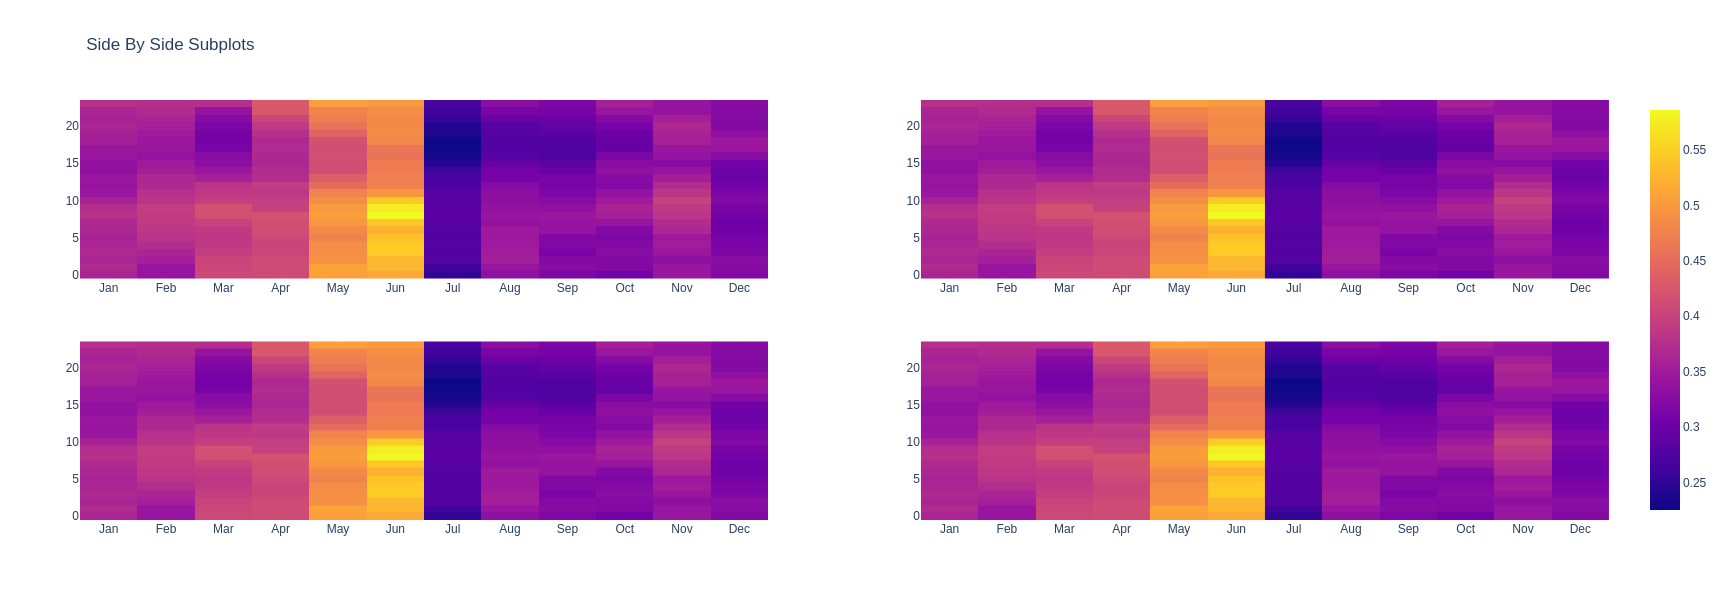

In [67]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=2, subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4"))

fig.add_trace(_.data[0], row=1, col=1)
fig.add_trace(_.data[0], row=1, col=2)
fig.add_trace(_.data[0], row=2, col=1)
fig.add_trace(_.data[0], row=2, col=2)

fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

In [63]:
# ignored for being 60 horizon
mlp_60 = Mert(["1wo20kk5", "1rdg2wjz", "olozkfwl", "lgzwtmz0"])
mlp_60_overall, mlp_60_week, mlp_60_date, mlp_60_hour, mlp_60_plant = mlp_60.generate("mlp_60")
mlp_60_overall

,wmape,bias,model
0,0.349027,-0.034812,mlp_60


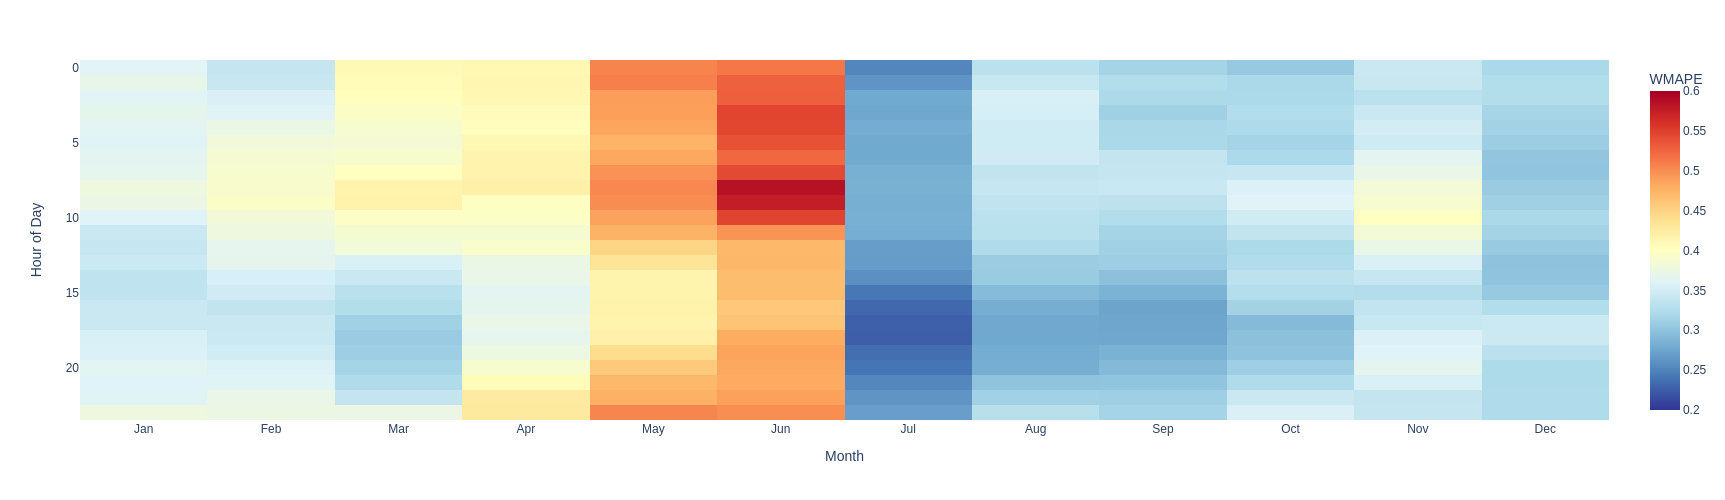

In [64]:
_ = mlp_60.plot_heatmap()

In [50]:
cnn = Mert(["2pw2oafo", "2ni8q5zy", "eix3jddl", "g55nqmkk"])
cnn_overall, cnn_week, cnn_date, cnn_hour, cnn_plant = cnn.generate("cnn")
cnn_overall

,wmape,bias,model
0,0.302746,-0.050161,cnn


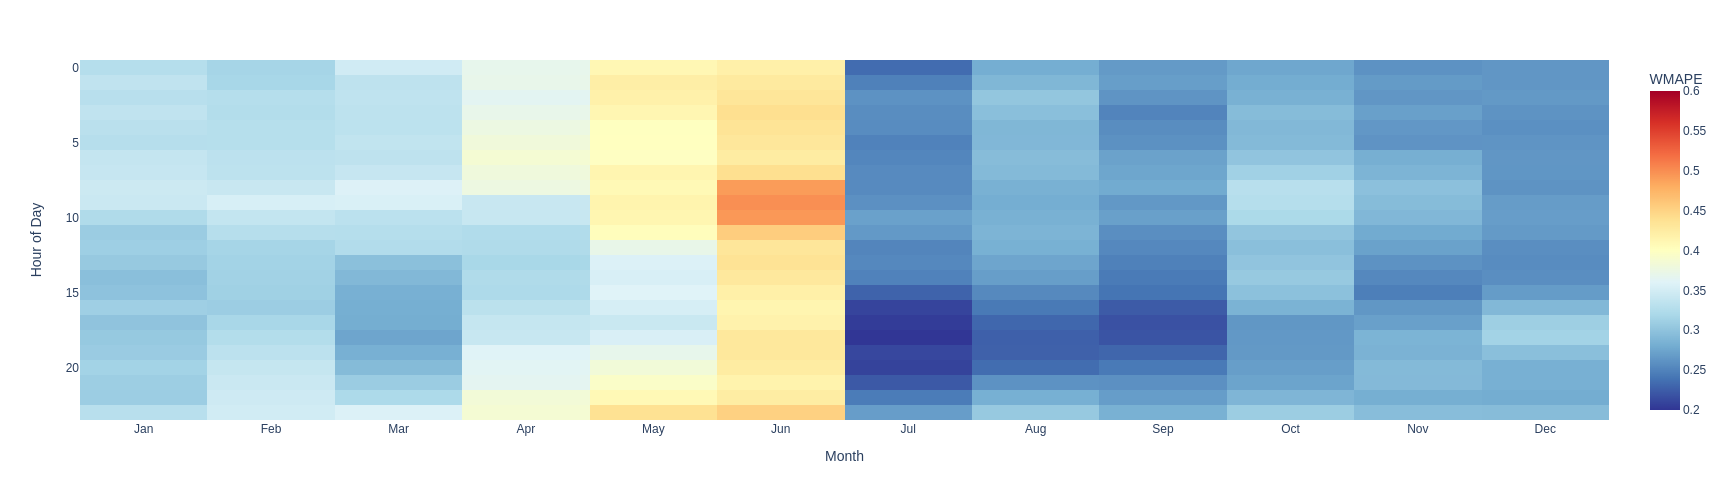

In [51]:
cnn.plot_heatmap()

In [53]:
lstm = Mert(["hj4494zp", "3f9mkyat", "10u5ruf3", "zhghndl6"])
lstm_overall, lstm_week, lstm_date, lstm_hour, lstm_plant = lstm.generate("lstm")
lstm_overall

,wmape,bias,model
0,0.335921,-0.04459,lstm


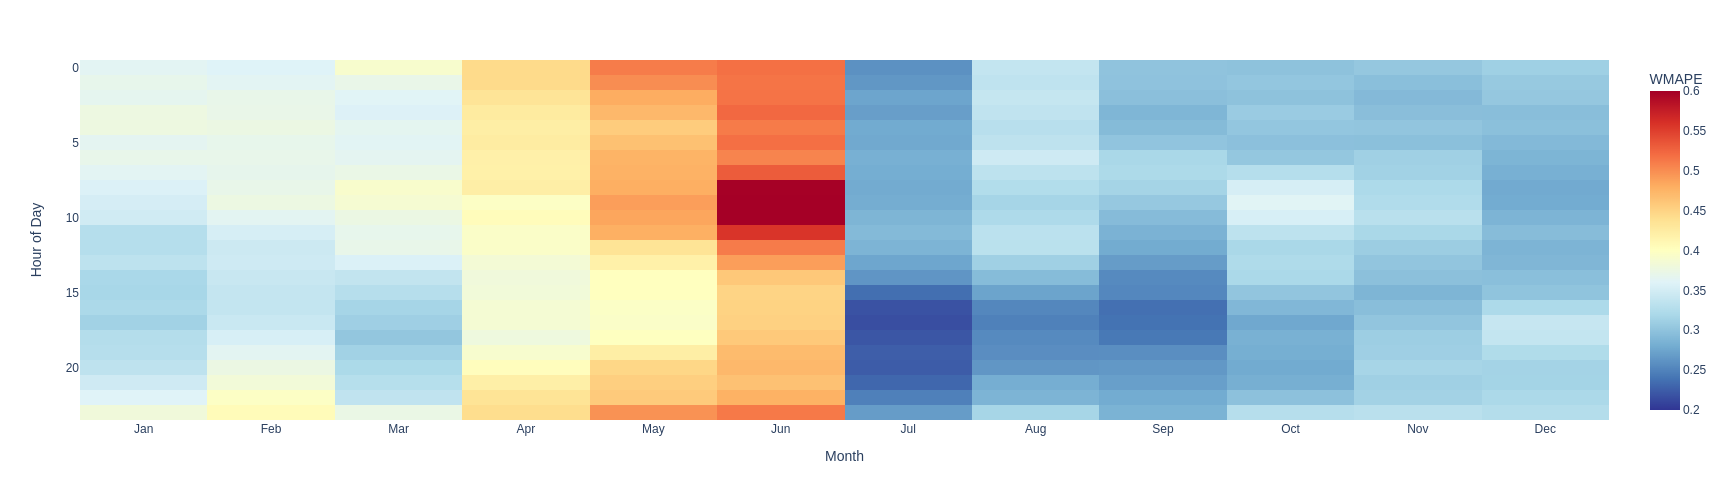

In [54]:
lstm.plot_heatmap()

In [56]:
gcn = Mert(["15lumdv6", "k3veoutz", "zd8r9nul", "tdedbtwi"])
gcn_overall, gcn_week, gcn_date, gcn_hour, gcn_plant = gcn.generate("gcn")
gcn_overall

,wmape,bias,model
0,0.343227,-0.031277,gcn


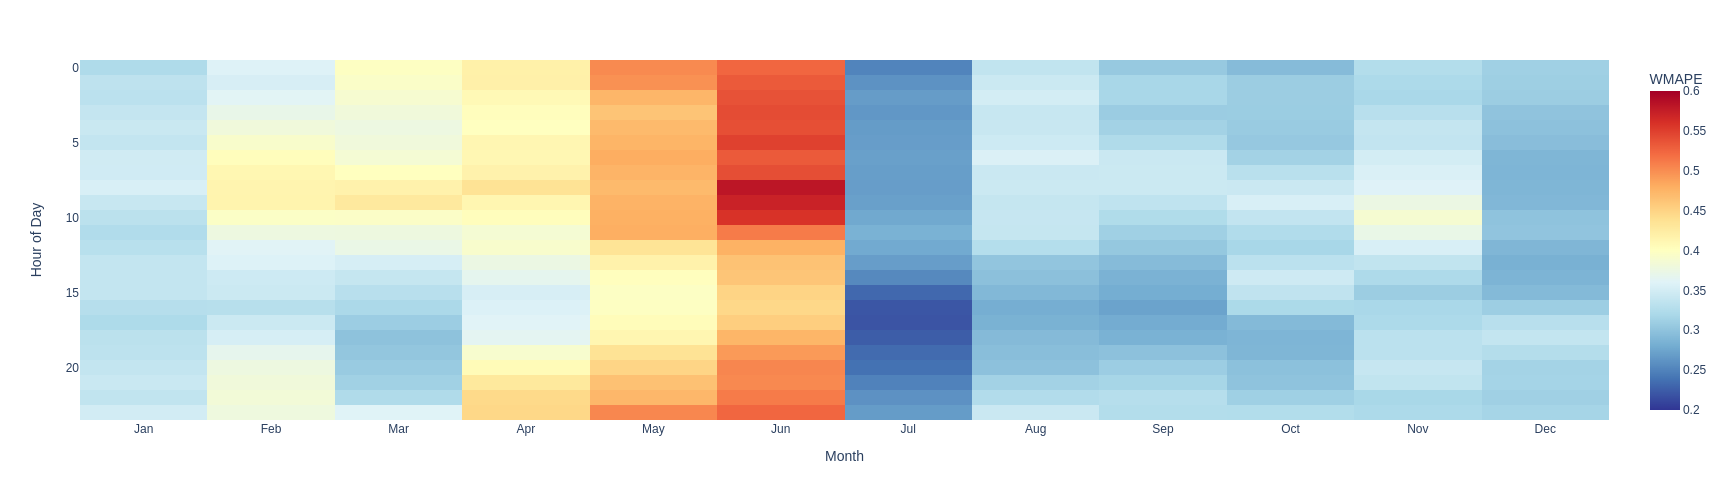

In [57]:
gcn.plot_heatmap()

In [58]:
cnnlstm = Mert(["jlmkr7nu", "32978v2g", "1n06n09w", "3giyf1gv"])
cnnlstm_overall, cnnlstm_week, cnnlstm_date, cnnlstm_hour, cnnlstm_plant = cnnlstm.generate("cnnlstm")
cnnlstm_overall

,wmape,bias,model
0,0.307795,-0.028593,cnnlstm


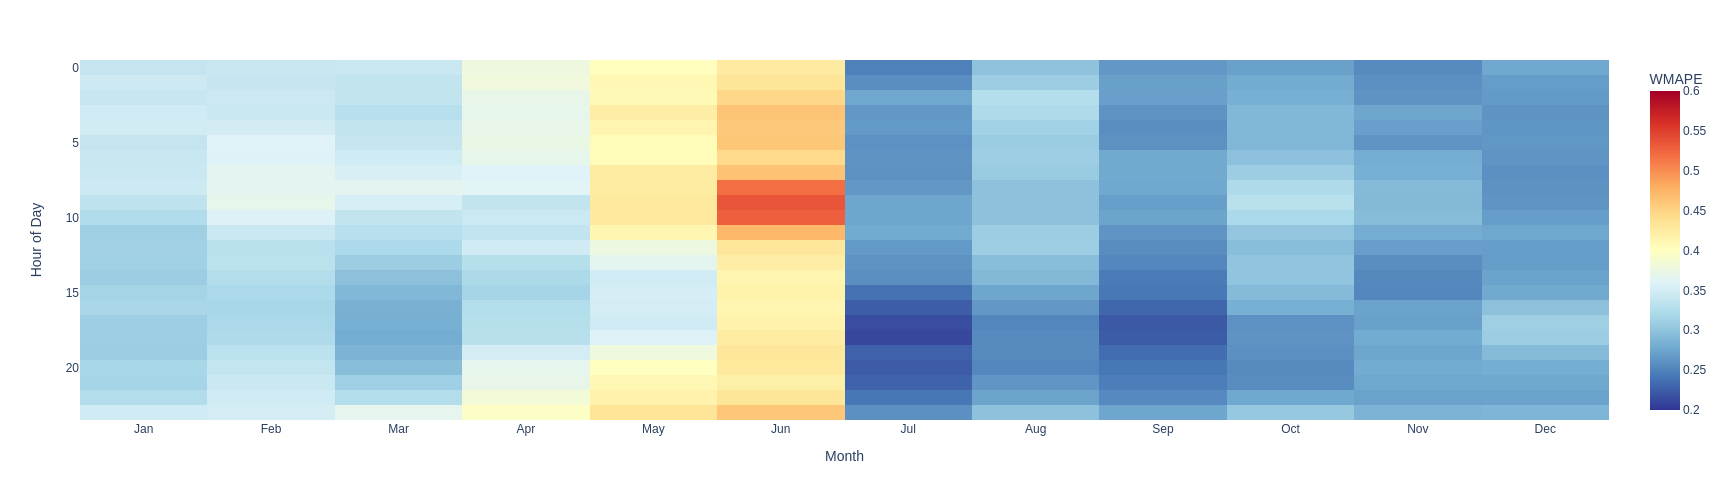

In [59]:
cnnlstm.plot_heatmap()

In [68]:
convlstm = Mert(["1kc87ka8", "1i8xmkm0", "1t9a1hee", "1x8fqcxy"])
convlstm_overall, convlstm_week, convlstm_date, convlstm_hour, convlstm_plant = convlstm.generate("convlstm")
convlstm_overall

,wmape,bias,model
0,0.306025,-0.061681,convlstm


In [69]:
# ignored for 60
mlp2_60 = Mert(["3plm4e3z", "3dmte7d9", "1xzjhuym", "2qz32dz2"])
mlp2_60_overall, mlp2_60_week, mlp2_60_date, mlp2_60_hour, mlp2_60_plant = mlp2_60.generate("mlp2_60")
mlp2_60_overall

,wmape,bias,model
0,0.354933,-0.03594,mlp2_60


In [70]:
mlp2 = Mert(["18m998io", "28y97tv2", "1b201aa1", "3vzxj048"])
mlp2_overall, mlp2_week, mlp2_date,mlp2_hour, mlp2_plant = mlp2.generate("mlp2")
mlp2_overall

,wmape,bias,model
0,0.373116,-0.034957,mlp2


In [92]:
mlp = Mert(["2wqd0a9h", "98w0pq58", "23ugpyx4", "3c9xs9yd"])
mlp_overall, mlp_week, mlp_date, mlp_hour, mlp_plant = mlp.generate("mlp")

In [93]:
mlp.data

,actuals,predictions,forecast_dt,rt_plant_id
0,0.322581,0.235979,2021-01-02 00:00:00,1472
1,0.225806,0.249820,2021-01-02 01:00:00,1472
2,0.258065,0.252885,2021-01-02 02:00:00,1472
3,0.258065,0.260366,2021-01-02 03:00:00,1472
4,0.258065,0.251460,2021-01-02 04:00:00,1472
...,...,...,...,...
196555,0.113312,0.220232,2021-12-31 19:00:00,1939
196556,0.073653,0.214690,2021-12-31 20:00:00,1939
196557,0.044853,0.207784,2021-12-31 21:00:00,1939
196558,0.090650,0.203934,2021-12-31 22:00:00,1939


In [96]:
lgb = pd.read_csv("/home/mert/Desktop/thesis/data/out/lightgbm_output.csv")
lgb["forecast_dt"] = pd.to_datetime(lgb["forecast_dt"])
name = "lgb"; lgb_metrics = Metrics(lgb); lgb_metrics.calculate()
lgb_overall, lgb_week, lgb_date, lgb_plant = lgb_metrics.to_df(name, "overall"), lgb_metrics.to_df(name, "week"), lgb_metrics.to_df(name, "date"), lgb_metrics.to_df(name, "rt_plant_id")
lgb_overall

,wmape,bias,model
0,0.342362,-0.05357,lgb


In [ ]:
# p_1 = pd.read_csv("/home/mert/Desktop/thesis/data/out/persistence1_output.csv")
# p_1["forecast_dt"] = pd.to_datetime(p_1["forecast_dt"])
# name = "p_1"; metrics = Metrics(p_1); metrics.calculate()
# p_1_overall, p_1_week, p_1_date, p_1_plant = metrics.to_df(name, "overall"), metrics.to_df(name, "week"), metrics.to_df(name, "date"), metrics.to_df(name, "rt_plant_id")
# p_1_overall

In [97]:
p_24 = pd.read_csv("/home/mert/Desktop/thesis/data/out/persistence24_output.csv")
p_24["forecast_dt"] = pd.to_datetime(p_24["forecast_dt"])
name = "p_24"; p_24metrics = Metrics(p_24); p_24metrics.calculate()
p_24_overall, p_24_week, p_24_date, p_24_plant = p_24metrics.to_df(name, "overall"), p_24metrics.to_df(name, "week"), p_24metrics.to_df(name, "date"), p_24metrics.to_df(name, "rt_plant_id")
p_24_overall

,wmape,bias,model
0,0.701161,0.000185,p_24


In [98]:
p_48 = pd.read_csv("/home/mert/Desktop/thesis/data/out/persistence48_output.csv")
p_48["forecast_dt"] = pd.to_datetime(p_48["forecast_dt"])
name = "p_48"; p_48metrics = Metrics(p_48); p_48metrics.calculate()
p_48_overall, p_48_week, p_48_date, p_48_plant = p_48metrics.to_df(name, "overall"), p_48metrics.to_df(name, "week"), p_48metrics.to_df(name, "date"), p_48metrics.to_df(name, "rt_plant_id")
p_48_overall

,wmape,bias,model
0,0.88809,0.001085,p_48


In [99]:
models = ["mlp", "cnn", "lstm", "gcn", "cnnlstm", "convlstm", "mlp2", "lgb", "p_24", "p_48"] # , "mlp2_48", "mlp_48"
models = ["mlp", "cnn", "lstm", "gcn", "cnnlstm", "convlstm", "mlp2", "lgb", "p_24", "p_48", "mlp2_60", "mlp_60"] # , "p_1"

In [100]:
overall = pd.concat([eval(f"{m}_overall") for m in models]).sort_values("wmape")
overall

,wmape,bias,model
0,0.302746,-0.050161,cnn
0,0.306025,-0.061681,convlstm
0,0.307795,-0.028593,cnnlstm
0,0.335921,-0.044590,lstm
0,0.342362,-0.053570,lgb
0,0.343227,-0.031277,gcn
0,0.349027,-0.034812,mlp_60
0,0.354933,-0.035940,mlp2_60
0,0.359364,-0.035382,mlp
0,0.373116,-0.034957,mlp2


In [78]:
week = pd.concat([eval(f"{m}_week") for m in models]).sort_values("wwmape_median")
week

,wwmape_median,wwmape_std,wbias_median,wbias_std,model
0,0.301867,0.104086,-0.051817,0.055422,cnn
0,0.316998,0.106123,-0.024929,0.064724,cnnlstm
0,0.323010,0.106357,-0.059229,0.065869,convlstm
0,0.344195,0.113082,-0.059168,0.090516,lgb
0,0.345976,0.119862,-0.046198,0.064943,lstm
0,0.357187,0.129853,-0.031232,0.080747,gcn
0,0.368204,0.137148,-0.037880,0.080595,mlp_60
0,0.377824,0.152994,-0.030428,0.104386,mlp2_60
0,0.388085,0.128764,-0.027175,0.083870,mlp
0,0.405916,0.141144,-0.021214,0.110127,mlp2


In [79]:
date = pd.concat([eval(f"{m}_date") for m in models]).sort_values("dwmape_median")
date

,dwmape_median,dwmape_std,dbias_median,dbias_std,model
0,0.390119,0.201037,-0.055059,0.136576,cnn
0,0.394742,0.200198,-0.063320,0.138498,convlstm
0,0.396099,0.227932,-0.020709,0.149925,cnnlstm
0,0.421076,0.268918,-0.027955,0.209875,lgb
0,0.432912,0.249686,-0.035047,0.161274,lstm
0,0.447957,0.245620,-0.026709,0.171030,gcn
0,0.448977,0.265595,-0.029713,0.183218,mlp_60
0,0.452017,0.268994,-0.016060,0.187080,mlp
0,0.456052,0.272275,-0.027746,0.189594,mlp2_60
0,0.468681,0.297165,-0.016715,0.239646,mlp2


In [80]:
plant = pd.concat([eval(f"{m}_plant") for m in models]).sort_values("pwmape_median")
plant

,pwmape_median,pwmape_std,pbias_median,pbias_std,model
0,0.304482,0.048104,-0.030538,0.066221,cnn
0,0.304546,0.049443,-0.040772,0.064716,convlstm
0,0.309527,0.052439,-0.009024,0.069130,cnnlstm
0,0.335675,0.056339,-0.019851,0.069230,lstm
0,0.336142,0.061375,-0.017574,0.090537,lgb
0,0.346698,0.051549,-0.036873,0.067966,gcn
0,0.347401,0.054253,-0.043693,0.073539,mlp_60
0,0.356875,0.056634,-0.040276,0.080107,mlp2_60
0,0.359786,0.059455,-0.033088,0.091790,mlp
0,0.375717,0.063198,-0.038514,0.102569,mlp2


In [81]:
cols = ["wmape_median", "wmape_std", "bias_median", "bias_std", "how"]
mlp2_date.columns = cols
mlp2_date["how"] = "Daily"
mlp2_week.columns = cols
mlp2_week["how"] = "Weekly"
mlp2_plant.columns = cols
mlp2_plant["how"] = "Plant"
pd.concat([mlp2_date, mlp2_week, mlp2_plant])

,wmape_median,wmape_std,bias_median,bias_std,how
0,0.468681,0.297165,-0.016715,0.239646,Daily
0,0.405916,0.141144,-0.021214,0.110127,Weekly
0,0.375717,0.063198,-0.038514,0.102569,Plant


# Visual

In [ ]:
low clusterlardaki hatalar, hish production clusterındaki hatalar ayrı ayrı görselle

In [ ]:
LOW = 1843
MEDIUM = 2323
HIGH = 1518

In [ ]:
cnn.data[cnn.data["rt_plant_id"] == LOW].groupby("date")[["actuals", "predictions"]].mean().plot(figsize=(30,10))

In [ ]:
cnn.data[cnn.data["rt_plant_id"] == MEDIUM].groupby("date")[["actuals", "predictions"]].mean().plot(figsize=(30,10))

In [ ]:
cnn.data[cnn.data["rt_plant_id"] == HIGH].groupby("date")[["actuals", "predictions"]].mean().plot(figsize=(30,10))

In [ ]:
mlp_48.data[mlp_48.data["rt_plant_id"] == HIGH].groupby("date")[["actuals", "predictions"]].mean().plot(figsize=(30,10))

In [ ]:
mlp

# Metrics

In [82]:
def prep_metrics(*names):
    dfs = []
    for name in names:
        dfs.append(eval(name).data.set_index(
            ["month", "rt_plant_id"]).rename(columns={"wmape": "wmape_"+name}))
    metrics = pd.concat(dfs, axis=1)
    rankings = metrics.rank(1, ascending=True, method='first')
    return metrics, rankings

In [91]:
mlp.data

,actuals,predictions,forecast_dt,rt_plant_id
0,0.322581,0.235979,2021-01-02 00:00:00,1472
1,0.225806,0.249820,2021-01-02 01:00:00,1472
2,0.258065,0.252885,2021-01-02 02:00:00,1472
3,0.258065,0.260366,2021-01-02 03:00:00,1472
4,0.258065,0.251460,2021-01-02 04:00:00,1472
...,...,...,...,...
196555,0.113312,0.220232,2021-12-31 19:00:00,1939
196556,0.073653,0.214690,2021-12-31 20:00:00,1939
196557,0.044853,0.207784,2021-12-31 21:00:00,1939
196558,0.090650,0.203934,2021-12-31 22:00:00,1939


In [102]:
dfs = []
for model in models:
    print(model)
    try:
        df = eval(model).metrics.df
    except:
        df = eval(f"{model}_metrics")
    wmape_ = df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
    wmape_.name = "wmape_" + model
    dfs.append(wmape_)
metrics = pd.concat(dfs, axis=1)
rankings = metrics.rank(1, ascending=True, method='first')


mlp
cnn
lstm
gcn
cnnlstm
convlstm
mlp2
lgb


AttributeError: 'Metrics' object has no attribute 'groupby'

In [ ]:
metrics

In [ ]:
rankings.mean()

In [85]:
metrics_melted = pd.melt(metrics, var_name="metric", ignore_index=False).reset_index()
rankings_melted = pd.melt(rankings, var_name="rank", ignore_index=False).reset_index()

AttributeError: 'Metrics' object has no attribute 'columns'

In [86]:
metrics.groupby("month").mean().rank(1, ascending=True, method='first')

AttributeError: 'Metrics' object has no attribute 'groupby'

In [87]:
metrics_melted

NameError: name 'metrics_melted' is not defined

In [88]:
fig = px.box(metrics_melted[metrics_melted["metric"].isin(["wmape_mlp", "wmape_mlp2"])], x="month", y="value", color="metric")
fig.show()

NameError: name 'metrics_melted' is not defined

In [ ]:
metrics

In [ ]:
rankings

In [ ]:
metrics[metrics.index.isin([1513], level=0)]

# Predictions

In [ ]:
fig = px.line(pd.melt(metrics.groupby(metrics.index.get_level_values(1)).mean(), ignore_index=False).reset_index(), x="month", y="value", color="variable")
fig.show()
# metrics.groupby("month").mean().plot()

In [ ]:
# fig = px.histogram(rankings_melted, x="month", y="value", color="rank")
# fig.show()

In [89]:
import Orange
import matplotlib.pyplot as plt
df = rankings.groupby("rt_plant_id").mean()
names = df.mean().index
avranks = df.mean().values

cd = Orange.evaluation.compute_CD(avranks, len(df))
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show()

NameError: name 'rankings' is not defined

In [ ]:
metrics_ = metrics
metrics_ordered = pd.concat([ 
    metrics_.T.apply(lambda x: x.nsmallest(i+1).idxmax())
    for i in range(metrics.shape[1])
], axis=1)
metrics_ordered.columns = [i+1 for i in range(metrics.shape[1])]
metrics_ordered = pd.melt(metrics_ordered, var_name="rank", value_name="method").value_counts().reset_index().rename(columns={0: "count"})
fig = px.bar(metrics_ordered.sort_values(["rank", "method"]), x="rank", y="count", color="method", title="Rank Occurences")
fig.show()

In [ ]:
metrics_ordered

In [ ]:
wandb.finish()